<a href="https://colab.research.google.com/github/matjesg/deepflash2/blob/master/paper/6_figures_tables.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# deepflash2 - Figures and Tables

> This notebook reproduces figures and tables from the deepflash2 [paper](https://arxiv.org/abs/2111.06693).

- **Source files**: The source files are available on [github](https://github.com/matjesg/deepflash2/releases/tag/paper_source_files) 
- **Data and results**: The data and results of the different methods are available on [Google Drive](https://drive.google.com/drive/folders/1r9AqP9qW9JThbMIvT0jhoA5mPxWEeIjs?usp=sharing). To use the data in Google Colab, create a [shortcut](https://support.google.com/drive/answer/9700156?hl=en&co=GENIE.Platform%3DDesktop) of the data folder in your personal Google Drive.

The preceding results can be reproduced using the notebooks on [github](https://github.com/matjesg/deepflash2/paper).

*References*:

Griebel, M., Segebarth, D., Stein, N., Schukraft, N., Tovote, P., Blum, R., & Flath, C. M. (2021). Deep-learning in the bioimaging wild: Handling ambiguous data with deepflash2. arXiv preprint arXiv:2111.06693.


## Setup


In [36]:
!pip install -Uq pingouin openpyxl

In [37]:
# Imports
import pingouin as pg 
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.stats.stats import pearsonr
import matplotlib as mpl

# Searborn settings
rc_params = {}#{'font.family': ['sans-serif'], 'font.sans-serif': ['Arial']}
sns.set(style='ticks', context='talk', rc=rc_params)

## General Settings


In [38]:
SOURCE_DATA_URL = 'https://github.com/matjesg/deepflash2/releases/download/paper_source_data/'
# Source data
df_speed = pd.read_excel(SOURCE_DATA_URL+'speed_comparison.xlsx')
df_semantic = pd.read_csv(SOURCE_DATA_URL+'semantic_segmentation_results.csv')
df_semantic_challenge = pd.read_csv(SOURCE_DATA_URL+'semantic_segmentation_results_challenge.csv')
df_instance = pd.read_csv(SOURCE_DATA_URL+'instance_segmentation_results.csv')
df_instance_agg = pd.read_csv(SOURCE_DATA_URL+'instance_segmentation_results_agg.csv')
df_instance_agg_challenge = pd.read_csv(SOURCE_DATA_URL+'instance_segmentation_results_agg_challenge.csv')
df_experts = pd.read_csv(SOURCE_DATA_URL+'STAPLE_vs_experts_all.csv')
df_experts_detailed = pd.read_csv(SOURCE_DATA_URL+'STAPLE_vs_experts_all_detailed.csv')
df_exp_uncertainties = pd.read_csv(SOURCE_DATA_URL+'experts_vs_uncertainties.csv')
df_ood = pd.read_csv(SOURCE_DATA_URL+'ood_detection.csv')
df_instance_reliability_agg = pd.read_csv(SOURCE_DATA_URL+'instance_segmentation_reliability_agg.csv')
df_semantic_reliability = pd.read_csv(SOURCE_DATA_URL+'semantic_segmentation_reliability.csv')
df_semantic = pd.read_csv(SOURCE_DATA_URL+'semantic_segmentation_results.csv')
df_speed = pd.read_excel(SOURCE_DATA_URL+'speed_comparison.xlsx')


colors = sns.color_palette("colorblind", 5)
COLORS = {'PV_in_HC':colors[1],
          'cFOS_in_HC':colors[4],
          'mScarlet_in_PAG':colors[0],
          'YFP_in_CTX':colors[2],
          'GFAP_in_HC':colors[3]}

CHALLENGE_COLORS = sns.color_palette("colorblind", 7)
CHALLENGE_COLORS

method_names = {
    'otsu': "Otsu's\n method*",
    'unet_2019': 'U-Net\n (2019)',
    'deepflash2': 'deepflash2\n (ours)', 
    'nnunet':'nnunet',
    'cellpose':'cellpose*',
    'cellpose_single': 'cellpose (single)',
    'cellpose_ensemble': 'cellpose\n (ensemble)'}

## Figure 3

### Figure 3a



- Predictive performance on the test sets for (b) semantic segmentation (N=40, 8
images for each dataset) 
  - measured by similarity to the estimated GT
  - grayscale filling depicts the comparison against the expert
annotation scores. 
- The p-values result from a two-sided Wilcoxon signed-rank test

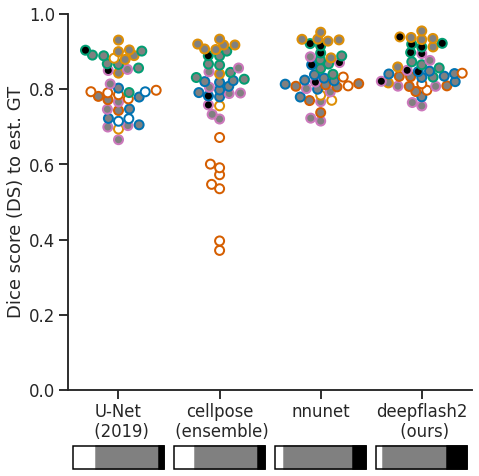

In [39]:
#@markdown Figure 3a code
# Settings
sns.set(style='ticks', context='talk')
metric = 'dice_score'
methods = ['unet_2019', 'cellpose_ensemble', 'nnunet', 'deepflash2']

# Data
df = df_semantic.copy()
df = df[(df.repetition==1) & (df.method.isin(methods))] # Only first set of experiments
df['colors'] = df['dataset'].apply(lambda x:COLORS[x])
df['method_formatted'] = df['method'].apply(lambda x:method_names[x])


ORDER = [method_names['unet_2019'],
         method_names['cellpose_ensemble'], 
         method_names['nnunet'], 
         method_names['deepflash2']]
    
HUE_ORDER = ['below worst expert', 
             'in expert range',  
             'above best expert']

# Plot
g = sns.catplot(y=metric, x="method_formatted", 
                hue='expert_comparison',
                palette=['white', 'grey', 'black'],
                edgecolors='black',
                linewidth=2.,
                order=ORDER,
                hue_order=HUE_ORDER,
                legend=False,
                height=7,
                data=df,  
                s=9,
                kind="swarm");

i=0
for method in ORDER:
    colors2 = df[df.method_formatted==method].sort_values(metric, ascending=True)['colors'].tolist()
    g.axes[0][0].get_children()[i].set_edgecolors(colors2)
    i+=1
    
g.set(ylim=(0., 1),
      xlabel='', 
      ylabel='Dice score (DS) to est. GT',
     )

# Bar settings
ax = g.axes[0][0]
y_offset = -0.15
x_start = 0.45
x_len = x_start*2
y_len = -0.06
rect_kwargs = {'fill':True, 'clip_on':False}

for i, method in enumerate(methods):
  df_tmp = df[df.method==method]
  below_exp = (df_tmp.expert_comparison=='below worst expert').mean()*x_len
  above_exp = (df_tmp.expert_comparison=='above best expert').mean()*x_len

  rect_white = patches.Rectangle((i-x_start,y_offset), x_len, y_len,
                                  fc=(0,0,0,0), ec='black', **rect_kwargs)
  
  rect_grey = patches.Rectangle((i-x_start+below_exp,y_offset), x_len-below_exp, 
                                y_len, fc='grey', ec='grey',**rect_kwargs)
  
  rect_black = patches.Rectangle((i+x_start-above_exp,y_offset), above_exp, 
                              y_len, fc='black', ec='black',**rect_kwargs)

  ax.add_patch(rect_grey)
  ax.add_patch(rect_black)
  ax.add_patch(rect_white)
plt.tight_layout()
plt.savefig('performance_dice.pdf');

In [40]:
#@markdown Figure 3a Wilcoxon signed-rank test
default_method = 'deepflash2'
x = df[(df.method==default_method)][metric].values

stats_list = []
for method, grp in df.groupby(['method']):
  if method!=default_method:
      y = grp[metric].values
      tmp = pg.wilcoxon(x, y, alternative='two-sided')
      tmp['method']=method
      stats_list.append(tmp)
pd.concat(stats_list)

,W-val,alternative,p-val,RBC,CLES,method
Wilcoxon,80.0,two-sided,9.471165e-06,0.804878,0.675625,cellpose_ensemble
Wilcoxon,142.0,two-sided,3.237106e-04,0.653659,0.580000,nnunet
Wilcoxon,23.0,two-sided,2.046523e-07,0.943902,0.691250,unet_2019


### Figure 3b



- Predictive performance on the test sets for instance segmentation (N=32, 8
images for each dataset) 
  - measured by similarity to the estimated GT
  - grayscale filling depicts the comparison against the expert
annotation scores. 
- The p-values result from a two-sided Wilcoxon signed-rank test

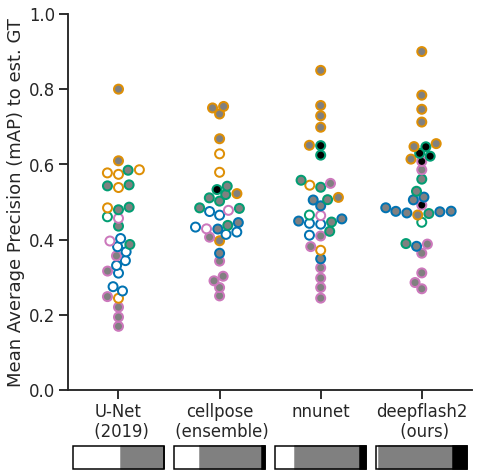

In [41]:
#@markdown Figure 3b code
# Settings
sns.set(style='ticks', context='talk')
metric = 'mean_average_precision'
methods = ['unet_2019', 'cellpose_ensemble', 'nnunet', 'deepflash2']

# Data
df = df_instance_agg.copy()
df = df[(df.repetition==1) & (df.method.isin(methods))] # Only first set of experiments
df['colors'] = df['dataset'].apply(lambda x:COLORS[x])
df['method_formatted'] = df['method'].apply(lambda x:method_names[x])


ORDER = [method_names['unet_2019'],
         method_names['cellpose_ensemble'], 
         method_names['nnunet'], 
         method_names['deepflash2']]
    
HUE_ORDER = ['below worst expert', 
             'in expert range',  
             'above best expert']

# Plot
g = sns.catplot(y=metric, x="method_formatted", 
                hue='expert_comparison',
                palette=['white', 'grey', 'black'],
                edgecolors='black',
                linewidth=2.,
                order=ORDER,
                hue_order=HUE_ORDER,
                legend=False,
                height=7,
                data=df,  
                s=9,
                kind="swarm");

i=0
for method in ORDER:
    colors2 = df[df.method_formatted==method].sort_values(metric, ascending=True)['colors'].tolist()
    g.axes[0][0].get_children()[i].set_edgecolors(colors2)
    i+=1
    
g.set(ylim=(0., 1),
      xlabel='', 
      ylabel='Mean Average Precision (mAP) to est. GT',
     );


ax = g.axes[0][0]

# Bar settings
y_offset = -0.15
x_start = 0.45
x_len = x_start*2
y_len = -0.06
rect_kwargs = {'fill':True, 'clip_on':False}

for i, method in enumerate(methods):
  df_tmp = df[df.method==method]
  below_exp = (df_tmp.expert_comparison=='below worst expert').mean()*x_len
  above_exp = (df_tmp.expert_comparison=='above best expert').mean()*x_len

  rect_white = patches.Rectangle((i-x_start,y_offset), x_len, y_len,
                                  fc=(0,0,0,0), ec='black', **rect_kwargs)
  
  rect_grey = patches.Rectangle((i-x_start+below_exp,y_offset), x_len-below_exp, 
                                y_len, fc='grey', ec='grey',**rect_kwargs)
  
  rect_black = patches.Rectangle((i+x_start-above_exp,y_offset), above_exp, 
                              y_len, fc='black', ec='black',**rect_kwargs)

  ax.add_patch(rect_grey)
  ax.add_patch(rect_black)
  ax.add_patch(rect_white)
plt.tight_layout()
plt.savefig('performance_map.pdf')

In [42]:
#@markdown Figure 3b Wilcoxon signed-rank test
default_method = 'deepflash2'
x = df[(df.method==default_method)][metric].values

stats_list = []
for method, grp in df.groupby(['method']):
  if method!=default_method:
      y = grp[metric].values
      tmp = pg.wilcoxon(x, y, alternative='two-sided')
      tmp['method']=method
      stats_list.append(tmp)
pd.concat(stats_list)

,W-val,alternative,p-val,RBC,CLES,method
Wilcoxon,87.0,two-sided,0.000966,0.670455,0.605469,cellpose_ensemble
Wilcoxon,67.0,two-sided,0.000238,0.746212,0.581055,nnunet
Wilcoxon,8.0,two-sided,0.000002,0.969697,0.708008,unet_2019


### Figure 3c


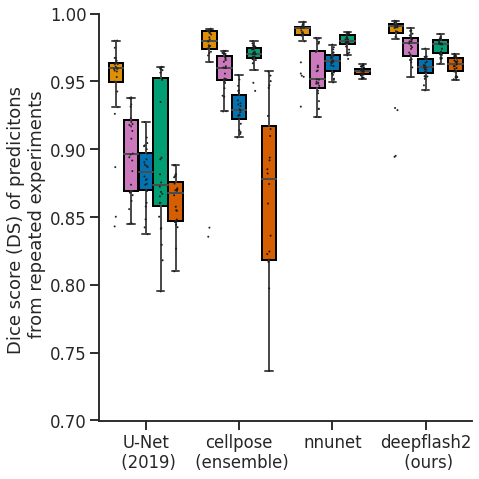

In [43]:
#@markdown Figure semantic reliability code
# Settings

metric = 'dice_score'
methods = ['unet_2019', 'cellpose_ensemble', 'nnunet', 'deepflash2']

# Data
df = df_semantic_reliability.copy()
df = df[df.method.isin(methods)] # Only first set of experiments
df['colors'] = df['dataset'].apply(lambda x:COLORS[x])
df['method_formatted'] = df['method'].apply(lambda x:method_names[x])

ORDER = [method_names[x] for x in methods]  

# Plot
g = sns.catplot(y=metric, x="method_formatted", 
                hue='dataset',
                #palette=['white', 'grey', 'black'],
                #edgecolors='black',
                linewidth=2.,
                order=ORDER,
                hue_order=COLORS.keys(),
                legend=False,
                height=7,
                data=df,  
                #s=10,
                showfliers=False,
                kind="box");


ax = g.axes[0][0]
for i,box in enumerate(ax.artists):
    #box.set_facecolor('white')
    #box.set_edgecolor(list(COLORS.values())[i%len(COLORS)])
    box.set_facecolor(list(COLORS.values())[i%len(COLORS)])
    box.set_edgecolor('black')

    
ax = sns.stripplot(
            x='method_formatted',
            y=metric,
            data=df,
            order=ORDER,
            hue='dataset',
            hue_order=COLORS.keys(),
            color='k',
            dodge=True,
            size=2
            )
ax.get_legend().remove()
    
g.set(ylim=(0.7, 1),
      xlabel='', 
      ylabel='Dice score (DS) of predicitons \n from repeated experiments',
     )

plt.tight_layout()
plt.savefig('reliability_dice.pdf');

### Figure 3d


Training durations on different platforms: Google Colaboratory (Colab, free Nvidia Tesla T4 GPU) and Google Cloud Platform (GPC, paid Nvidia A100 GPU)

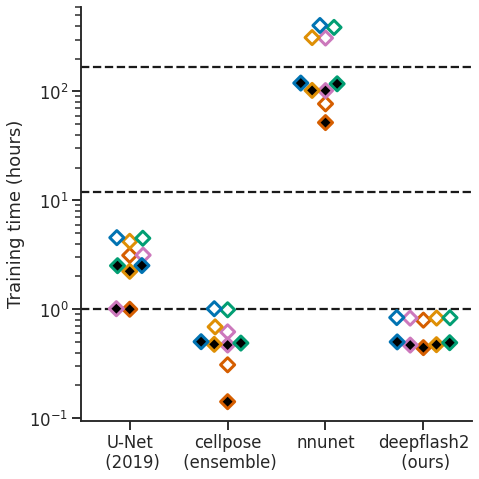

In [44]:
#@markdown Figure Seepd code
# Settings
sns.set(style='ticks', context='talk')
metric='hours'

# Data
df_speed['minutes'] = df_speed['time']/60
df_speed['method_formatted'] = df_speed['method'].apply(lambda x:method_names[x])

ORDER = [method_names['unet_2019'], 
         method_names['cellpose_ensemble'], 
         method_names['nnunet'], 
         method_names['deepflash2']]

PAL = {'free (T4)':'white',
      'paid (A100)':'black'}

# Plot
g = sns.catplot(
    order=ORDER, 
    data=df_speed,
    x='method_formatted',
    y=metric,
    kind='strip',
    palette=['white'],
    height=7,
    #aspect=.8,
    dodge=False)

g.set(yscale="log")

for gpu, grp in df_speed.groupby('GPU'):
    colors2 = grp['dataset'].apply(lambda x:COLORS[x]).to_list()
    ax = sns.swarmplot(
        order=ORDER, 
        data=grp,
        x='method_formatted',
        marker="D",
        y=metric,
        palette=[PAL[gpu]],
        edgecolor=colors2,
        s=10,
        linewidth=3.
    )

g.axes[0][0].axhline(12, ls='--', c='k')
g.axes[0][0].axhline(1, ls='--', c='k')
g.axes[0][0].axhline(168, ls='--', c='k')

g.set(xlabel='', 
      ylabel='Training time (hours)',
     )

plt.tight_layout()
plt.savefig('speed.pdf');

### Figure 4a

Correlation between dice scores and uncertainties on the test set 

'R^2=0.5668307602644167, (p = 2.094147848186296e-08)'

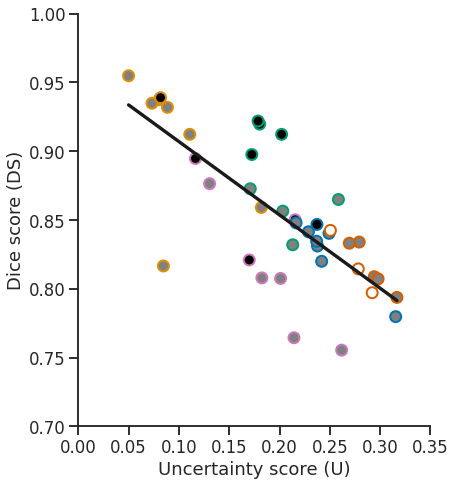

In [45]:
#@markdown Figure 4a code
# Settings
sns.set(style='ticks', context='talk')
metric = 'dice_score'
x='uncertainty_score'

# Data
df = df_semantic.copy()
df = df[df.repetition==1] # Only first set of experiments
df = df[df.method=='deepflash2'] 
df['colors'] = df['dataset'].apply(lambda x:COLORS[x])

# Calculate R^2
r, p = pearsonr(df[x], df[metric])
display(f"R^2={r**2}, (p = {p})")

HUE_ORDER = ['below worst expert', 'in expert range',  'above best expert']
colors2 = df['dataset'].apply(lambda x:COLORS[x]).to_list()

# Plot
g = sns.relplot(
data=df,
    x=x,
    y=metric,
    hue='expert_comparison',
    hue_order=HUE_ORDER,
    s=120,
    linewidth=2.,
    height=7,
    palette=['white', 'grey', 'black'],
)
g.axes[0][0].get_children()[0].set_edgecolors(colors2)
    
ax = sns.regplot(x=x,
                y=metric,
                data=df, 
                x_estimator=None, 
                x_bins=None, 
                ci=None, 
                color='k',
                scatter=False, 
                fit_reg=True)

g.set(xlim=(0,0.35),
      ylim=(0.70,1),
      xlabel='Uncertainty score (U)', 
      ylabel='Dice score (DS)',
     )
g.legend.set_title('Dataset')
g.legend.remove();
#plt.tight_layout()
plt.savefig('dice_vs_uncertainty.pdf');

In [46]:
np.sqrt(0.566830)

0.7528811327161812

### Figure 4b

Relationship between pixel-wise uncertainty and
- expert agreement (at least one expert with differing annotation)
- average prediction error rate (relative frequency of deviations between different expert segmentations and the predicted segmentation)

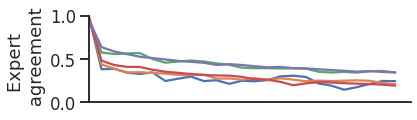

In [47]:
#@markdown Figure 4b expert agreement code
# Settings
sns.set(style='ticks', context='talk')

# Plot
g = sns.relplot(data=df_exp_uncertainties,
            x="uncertainty_bins", 
            y="expert_agreement",  
            hue='dataset',
            hue_order=COLORS.keys(),
            height=2.5,
            aspect=2.4,
            ci = None,
            color='k',
            kind='line',
            legend=False
           )
g.set(ylim=(0., 1),
      xlim=(0.,None),
      xlabel='',
      yticks=[0,0.5,1],
      xticks=[],
      xticklabels='',
      ylabel='Expert \n agreement',
     )
sns.despine(trim=False, left=False, bottom=False);
plt.savefig('expert_agreement_uncertainty.pdf');

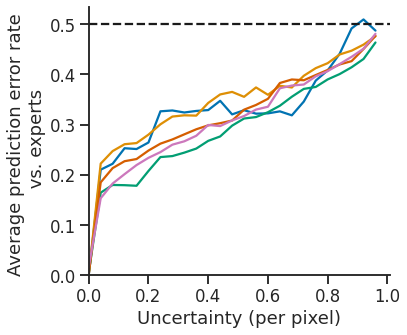

In [48]:
#@markdown Figure 4b average prediction error rate code
# Settings
sns.set(style='ticks', context='talk')

# Plot
g = sns.relplot(
    data=df_exp_uncertainties, 
    x="uncertainty_bins", 
    y="error_rate", 
    palette=colors[:5],
    hue_order=COLORS.keys(),
    ci=None,
    height=5,
    aspect=1.2,
     hue="dataset", 
    kind="line",
    legend=False
    )
ax = g.axes[0][0]
ax.axhline(0.5, ls='--', c='k')

g.set(xlim=(0,None),
      ylim=(0,None),
      xlabel='Uncertainty (per pixel)', 
      ylabel='Average prediction error rate \n vs. experts',
     );
plt.tight_layout()
plt.savefig('pixel_uncertainty.pdf');

### Figure 5a

Out-of-distribution (ood) detection performance using heuristic ranking via uncertainty score

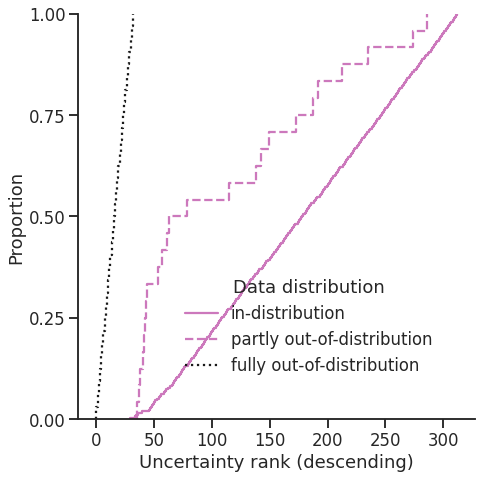

In [49]:
#@markdown Figure 5a code
sns.set(style='ticks', context='talk')

ORDER = ['in-distribution', 'partly out-of-distribution', 'fully out-of-distribution']
LS=['solid', 'dashed', 'dotted']

g = sns.displot(data=df_ood, 
            x='rank', 
            hue="data_distribution", 
            hue_order=ORDER,
            kind="ecdf", 
            legend=True,
            height=7,
           );

rev = list(range(3))[::-1]
for i, ls in enumerate(LS):
    line = g.axes[0][0].lines[rev[i]]
    line.set_linestyle(ls)
    g.legend.legendHandles[i].set_linestyle(ls)
    if i==2: 
        line.set_color('k')
        g.legend.legendHandles[i].set_color('k')
    else:
        line.set_color(colors[4])
        g.legend.legendHandles[i].set_color(colors[4])
        
g.set(
      xlabel='Uncertainty rank (descending)', 
      ylabel='Proportion',
      yticks = list(np.arange(0,1.1, 0.25))
     )

#g.set(xlim=(0,None))
g.legend.set_title('Data distribution')
g.legend.set_bbox_to_anchor((1.15,0.3), transform = ax.transAxes);
#plt.tight_layout()
plt.savefig('uncertainty_rank.pdf');

## Figure 6

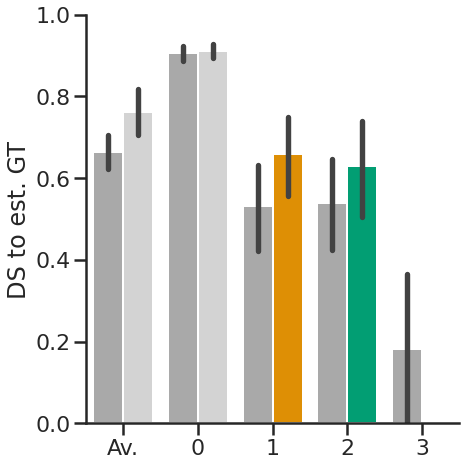

In [50]:
#@markdown Figure performance gleason code
# Settings
sns.set(style='ticks', context='poster')

metric = 'dice_score'
methods = ['nnunet', 'deepflash2']
dataset = ['gleason']
repetitions = [1]

# Data
df = df_semantic_challenge.copy()
df = df[df.repetition.isin(repetitions)] # Only first set of experiments
df = df[df.method.isin(methods)] # Filter methods
df = df[df.dataset.isin(dataset)] # Filter datasets
df['method_formatted'] = df['method'].apply(lambda x:method_names[x])
df['dice_score_average'] = df['average_dice_score']
df_long = pd.wide_to_long(df, stubnames='dice_score', i=['method', 'repetition', 'idx'], j='group', suffix='\w+').reset_index()
#df_long = df_long[~df_long['group'].isin([f'_class{i}' for i in range(4,7)])]

ORDER = ['_average', '_class0', '_class1', '_class2', '_class3']
HUE_ORDER = [method_names[x] for x in methods]  

# Plot
g = sns.catplot(y=metric, 
                x="group", 
                hue='method_formatted',
                palette=['darkgrey', 'lightgrey'],
                order=ORDER,
                hue_order=HUE_ORDER,
                #edgecolor=".05",
                legend=False,
                height=7,
                data=df_long,  
                #aspect=.8,
                kind="bar");


# extract the matplotlib axes_subplot objects from the FacetGrid
ax = g.axes[0][0]

# iterate through the axes containers
i = 0
for bar in ax.patches:
    if i==7: bar.set_facecolor(CHALLENGE_COLORS[1])
    if i==8: bar.set_facecolor(CHALLENGE_COLORS[2])
    i += 1
    
g.set(ylim=(0, 1),
      xlabel='', 
      #xticklabels=['Average',
      #             'Other', 
      #             'Grade 3',
      #             'Grade 4', 
      #             'Grade 5', 
      #             ],
    xticklabels=['Av.', '0', '1', '2', '3'],
    ylabel='DS to est. GT',
     )

#g.set_xticklabels(rotation=90)

plt.tight_layout()
plt.savefig('dice_comparison_gleason.pdf');

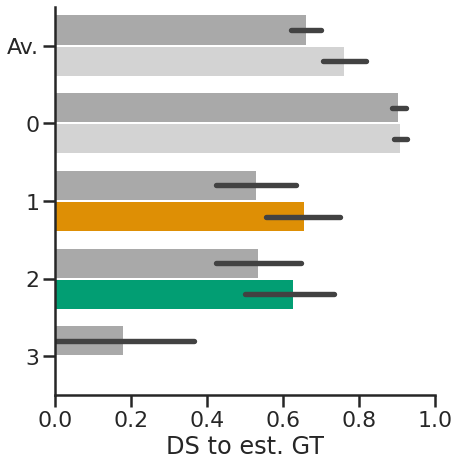

In [51]:
#@markdown Figure performance gleason code
# Settings
sns.set(style='ticks', context='poster')
metric = 'dice_score'
methods = ['nnunet', 'deepflash2']
dataset = ['gleason']
repetitions = [1]

# Data
df = df_semantic_challenge.copy()
df = df[df.repetition.isin(repetitions)] # Only first set of experiments
df = df[df.method.isin(methods)] # Filter methods
df = df[df.dataset.isin(dataset)] # Filter datasets
df['method_formatted'] = df['method'].apply(lambda x:method_names[x])
df['dice_score_average'] = df['average_dice_score']
df_long = pd.wide_to_long(df, stubnames='dice_score', i=['method', 'repetition', 'idx'], j='group', suffix='\w+').reset_index()
#df_long = df_long[~df_long['group'].isin([f'_class{i}' for i in range(4,7)])]

ORDER = ['_average', '_class0', '_class1', '_class2', '_class3']
HUE_ORDER = [method_names[x] for x in methods]  

# Plot
g = sns.catplot(x=metric, 
                y="group", 
                hue='method_formatted',
                palette=['darkgrey', 'lightgrey'],
                order=ORDER,
                hue_order=HUE_ORDER,
                orient='h',
                #edgecolor=".05",
                legend=False,
                height=7,
                data=df_long,  
                #aspect=.8,
                kind="bar");


# extract the matplotlib axes_subplot objects from the FacetGrid
ax = g.axes[0][0]

# iterate through the axes containers
i = 0
for bar in ax.patches:
    if i==7: bar.set_facecolor(CHALLENGE_COLORS[1])
    if i==8: bar.set_facecolor(CHALLENGE_COLORS[2])
    i += 1
    
g.set(xlim=(0, 1),
      ylabel='', 
    #  yticklabels=['Class \nAverage',
    #               'Other', 
    #               'Grade 3',
    #               'Grade 4', 
    #               'Grade 5', 
    #               ],
    yticklabels=['Av.', '0', '1', '2', '3'],
      xlabel='DS to est. GT',
     )

#g.set_xticklabels(rotation=90)

plt.tight_layout()
plt.savefig('dice_comparison_gleason.pdf');

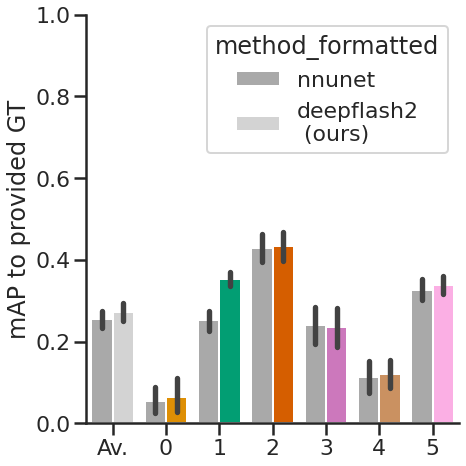

In [52]:
#@markdown Figure performance conic code
# Settings

metric = 'mAP'
methods = ['nnunet', 'deepflash2']
dataset = ['conic']
repetitions = [1] # Only first set of experiments

# Data
df = df_instance_agg_challenge.copy()
df = df[df.repetition.isin(repetitions)] 
df = df[df.method.isin(methods)] 
df = df[df.dataset.isin(dataset)]
df['method_formatted'] = df['method'].apply(lambda x:method_names[x])
df['mAP_average'] = df['average_mAP']
df_long = pd.wide_to_long(df, stubnames='mAP', i=['method', 'repetition', 'idx'], j='group', suffix='\w+').reset_index()
#df_long = df_long[~df_long['group'].isin([f'_class{i}' for i in range(4,7)])]


ORDER = ['_average'] + [f'_class{i}' for i in range(1,7)]
HUE_ORDER = [method_names[x] for x in methods]  

# Plot
g = sns.catplot(y=metric, 
                x="group", 
                hue='method_formatted',
                palette=['darkgrey', 'lightgrey'],
                order=ORDER,
                hue_order=HUE_ORDER,
                #orient='h',
                #legend=False,
                legend_out = False,
                height=7,
                data=df_long,  
                aspect=1,
                kind="bar");

# extract the matplotlib axes_subplot objects from the FacetGrid
ax = g.axes[0][0]

# iterate through the axes containers
i = 0
for bar in ax.patches:
    if i>7:
        bar.set_facecolor(CHALLENGE_COLORS[i-7])
    i += 1
    
g.set(ylim=(0, 1),
      xlabel='', 
      #xticklabels=['Class\nAverage',
      #             'Epithelial', 
      #             'Lymphocyte',
      #             'Plasma', 
      ##             'Eosinophil', 
      #             'Neutrophil', 
      #             'Connective\ntissue',
       #            ],
      xticklabels=['Av.','0', '1', '2', '3','4', '5', '6'],
      ylabel='mAP to provided GT',
     )


plt.tight_layout()
plt.savefig('mAP_comparison_conic.pdf');

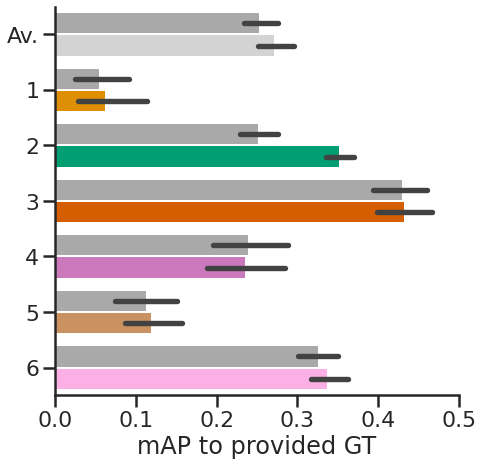

In [53]:
#@markdown Figure performance conic code
# Settings

metric = 'mAP'
methods = ['nnunet', 'deepflash2']
dataset = ['conic']
repetitions = [1] # Only first set of experiments

# Data
df = df_instance_agg_challenge.copy()
df = df[df.repetition.isin(repetitions)] 
df = df[df.method.isin(methods)] 
df = df[df.dataset.isin(dataset)]
df['method_formatted'] = df['method'].apply(lambda x:method_names[x])
df['mAP_average'] = df['average_mAP']
df_long = pd.wide_to_long(df, stubnames='mAP', i=['method', 'repetition', 'idx'], j='group', suffix='\w+').reset_index()
#df_long = df_long[~df_long['group'].isin([f'_class{i}' for i in range(4,7)])]


ORDER = ['_average'] + [f'_class{i}' for i in range(1,7)]
HUE_ORDER = [method_names[x] for x in methods]  

# Plot
g = sns.catplot(x=metric, 
                y="group", 
                hue='method_formatted',
                palette=['darkgrey', 'lightgrey'],
                order=ORDER,
                hue_order=HUE_ORDER,
                orient='h',
                legend=False,
                height=7,
                data=df_long,  
                aspect=1,
                kind="bar");

# extract the matplotlib axes_subplot objects from the FacetGrid
ax = g.axes[0][0]

# iterate through the axes containers
i = 0
for bar in ax.patches:
    if i>7:
        bar.set_facecolor(CHALLENGE_COLORS[i-7])
    i += 1
    
g.set(xlim=(0, .5),
      ylabel='', 
      #yticklabels=['Class\nAverage',
      #             'Epithelial', 
      #             'Lymphocyte',
      #             'Plasma', 
      #             'Eosinophil', 
     #              'Neutrophil', 
     #              'Connective\ntissue',
      #             ],
      yticklabels=['Av.', '1', '2', '3','4', '5', '6'],
      xlabel='mAP to provided GT',
     )


plt.tight_layout()
plt.savefig('mAP_comparison_conic.pdf');

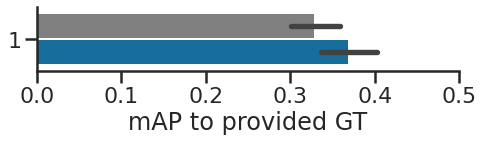

In [54]:
#@markdown Figure performance conic code
# Settings

metric = 'mAP_class1'
methods = ['nnunet', 'deepflash2']
dataset = ['monuseg']
repetitions = [1] # Only first set of experiments

# Data
df = df_instance_agg_challenge.copy()
df = df[df.repetition.isin(repetitions)] 
df = df[df.method.isin(methods)] 
df = df[df.dataset.isin(dataset)] 
df['method_formatted'] = df['method'].apply(lambda x:method_names[x])

ORDER = [method_names[x] for x in methods]  

# Plot
g = sns.catplot(x=metric, 
                y="dataset", 
                hue='method_formatted',
                palette=['grey', CHALLENGE_COLORS[0]],
                hue_order=ORDER,
                orient='h',
                legend=False,
                height=2.5,
                data=df,  
                aspect=2.8,
                kind="bar");



    
g.set(xlim=(0, .5),
      ylabel='', 
      yticklabels=['1'],
      xlabel='mAP to provided GT',
     )

#g.set_xticklabels(rotation=90)

plt.tight_layout()
plt.savefig('mAP_comparison_monuseg.pdf');

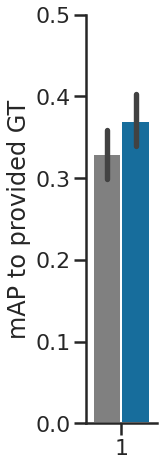

In [55]:
#@markdown Figure performance conic code
# Settings

metric = 'mAP_class1'
methods = ['nnunet', 'deepflash2']
dataset = ['monuseg']
repetitions = [1] # Only first set of experiments

# Data
df = df_instance_agg_challenge.copy()
df = df[df.repetition.isin(repetitions)] 
df = df[df.method.isin(methods)] 
df = df[df.dataset.isin(dataset)] 
df['method_formatted'] = df['method'].apply(lambda x:method_names[x])

ORDER = [method_names[x] for x in methods]  

# Plot
g = sns.catplot(y=metric, 
                x="dataset", 
                hue='method_formatted',
                palette=['grey', CHALLENGE_COLORS[0]],
                hue_order=ORDER,
                legend=False,
                height=7,
                data=df,  
                aspect=.4,
                kind="bar");


    
g.set(ylim=(0, .5),
      xlabel='', 
      xticklabels=['1'],
      ylabel='mAP to provided GT',
     )

#g.set_xticklabels(rotation=90)

plt.tight_layout()
plt.savefig('mAP_comparison_monuseg.pdf');

## Supplementary Figures and Tables

### Figure S2.1

Expert annotation performance. The expert annotation performance is measured by the experts’ annotation similarity to the estimated ground truth (STAPLE). 

GFAP_in_HC


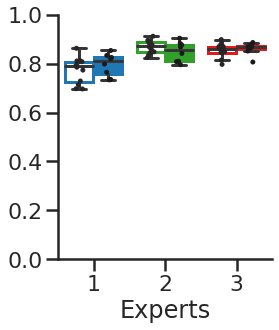

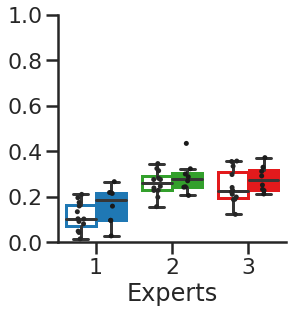

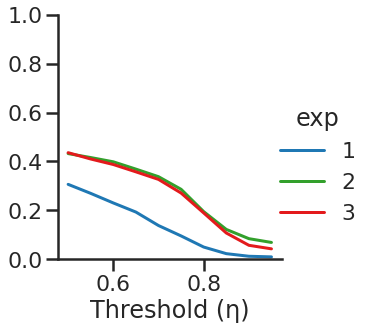

PV_in_HC


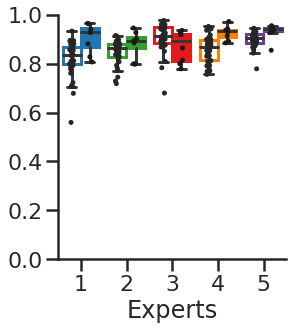

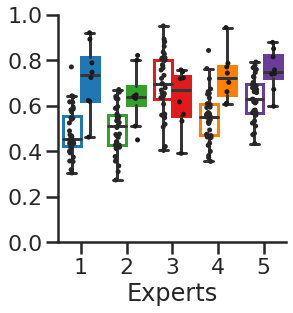

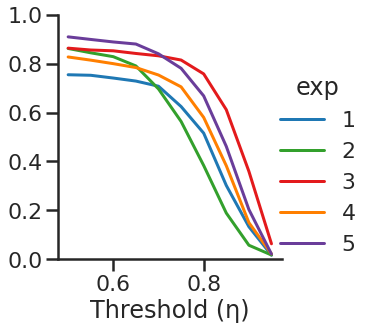

YFP_in_CTX


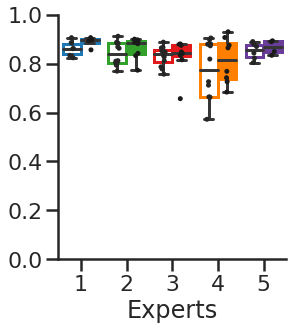

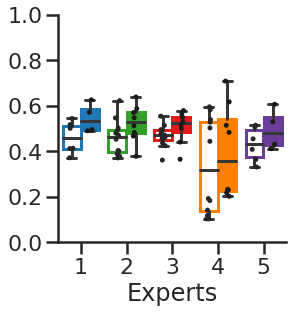

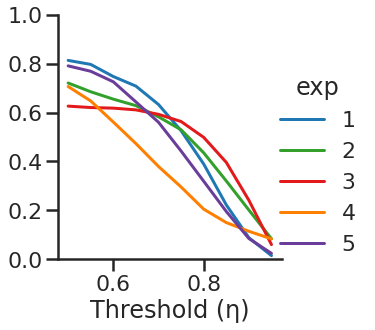

cFOS_in_HC


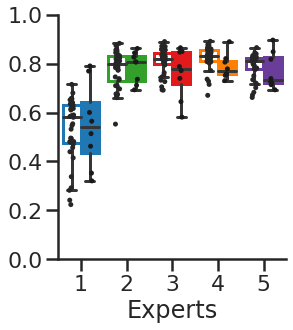

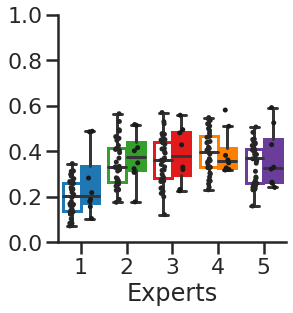

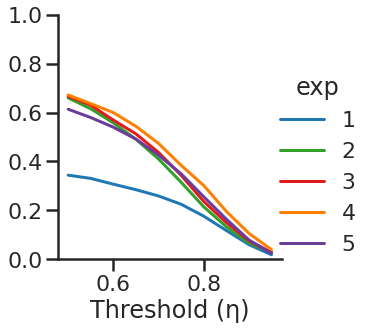

mScarlet_in_PAG


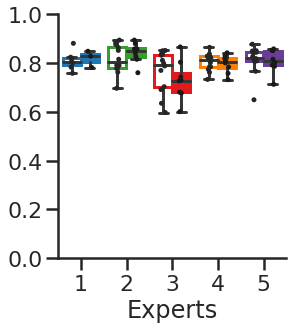

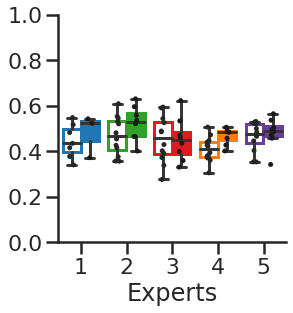

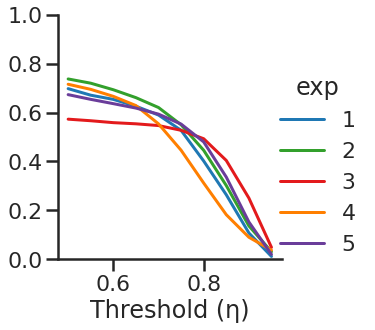

In [56]:
#@markdown Expert performance figure code
cmap = sns.color_palette('Paired', 11)
cmap2 = cmap[1::2]
x='exp'

for ds, grp in df_experts.groupby('dataset'):
    print(ds)
    for m in ['dice_score', 'mean_average_precision']:
        g = sns.catplot(
                    x=x,
                    y=m,
                    data=grp,
                    hue='subset',
                    hue_order=['train', 'test'],
                    height=5, 
                    aspect=1,# 
                    palette="colorblind",
                    kind="box", 
                    legend=False,
                    fliersize=0,
                    )
        
        ax = g.axes[0][0]
        j = 0
        for i,box in enumerate(ax.artists):
            box.set_facecolor('white')
            box.set_edgecolor(cmap2[j])
            if i%2==1: 
                box.set_facecolor(cmap2[j])
                j+=1

            
        ax = sns.stripplot(
                    x=x,
                    y=m,
                    data=grp,
                    hue='subset',
                    hue_order=['train', 'test'],
                    color='k',
                    dodge=True
                    )
        ax.get_legend().remove()
        g.set(ylim=(0,1),
              xlabel='Experts', 
              ylabel='',)
        plt.show()
        
    g = sns.relplot(
    data=df_experts_detailed[df_experts_detailed.dataset==ds], 
    x='threshold', y='ap',
    ci=None,
    hue=x, 
    palette=cmap2[:len(df_experts_detailed[df_experts_detailed.dataset==ds].exp.unique())],
    kind="line",
    height=5,
    )

    g.set(ylim=(0,1), xlabel='Threshold (η)', ylabel='')
    plt.show()

### Table S2.1

Methods performance comparison. Average predictive performance measured by similarity to the estimated ground truth (STAPLE) on the hold-out test sets (N = 8 images for each dataset) over three repetitions.

In [57]:
#@markdown Semantic segmentation performance
metric = 'dice_score'
(df_semantic.groupby(['method', 'dataset','repetition'])[[metric]]
.agg('mean').groupby(['dataset','method'])
.agg(('mean', 'std'))
.round(3))

dice_score       
                                        mean    std
dataset         method                             
GFAP_in_HC      cellpose               0.167  0.000
                cellpose_ensemble      0.541  0.023
                cellpose_single        0.365  0.073
                deepflash2             0.817  0.001
                nnunet                 0.799  0.000
                otsu                   0.601  0.000
                unet_2019              0.763  0.015
PV_in_HC        cellpose               0.806  0.000
                cellpose_ensemble      0.885  0.008
                cellpose_single        0.874  0.009
                deepflash2             0.910  0.010
                nnunet                 0.891  0.002
                otsu                   0.101  0.000
                unet_2019              0.863  0.010
YFP_in_CTX      cellpose               0.742  0.000
                cellpose_ensemble      0.870  0.005
                cellpose_single        0.860  0.011
                deepflash2             0.884  0.002
                nnunet                 0.883  0.000
                otsu                   0.743  0.000
                unet_2019              0.850  0.037
cFOS_in_HC      cellpose               0.597  0.000
                cellpose_ensemble      0.792  0.006
                cellpose_single        0.776  0.013
                deepflash2             0.822  0.002
                nnunet                 0.797  0.000
                otsu                   0.033  0.000
                unet_2019              0.769  0.010
mScarlet_in_PAG cellpose               0.434  0.000
                cellpose_ensemble      0.802  0.002
                cellpose_single        0.787  0.006
                deepflash2             0.830  0.000
                nnunet                 0.821  0.002
                otsu                   0.156  0.000
                unet_2019              0.756  0.008

In [58]:
#@markdown Instance segmentation performance
metric = 'mean_average_precision'
(df_instance_agg.groupby(['method', 'dataset','repetition'])[[metric]]
.agg('mean').groupby(['dataset','method'])
.agg(('mean', 'std'))
.round(3))

mean_average_precision       
                                                    mean    std
dataset         method                                         
PV_in_HC        cellpose                           0.541  0.000
                cellpose_ensemble                  0.628  0.028
                cellpose_single                    0.610  0.012
                deepflash2                         0.689  0.020
                nnunet                             0.643  0.004
                unet_2019                          0.548  0.024
YFP_in_CTX      cellpose                           0.304  0.000
                cellpose_ensemble                  0.511  0.010
                cellpose_single                    0.499  0.014
                deepflash2                         0.536  0.006
                nnunet                             0.527  0.003
                unet_2019                          0.455  0.059
cFOS_in_HC      cellpose                           0.268  0.000
                cellpose_ensemble                  0.350  0.004
                cellpose_single                    0.329  0.010
                deepflash2                         0.412  0.003
                nnunet                             0.368  0.002
                unet_2019                          0.305  0.016
mScarlet_in_PAG cellpose                           0.143  0.000
                cellpose_ensemble                  0.432  0.002
                cellpose_single                    0.415  0.004
                deepflash2                         0.469  0.003
                nnunet                             0.443  0.002
                unet_2019                          0.337  0.003

In [59]:
#@markdown Detection performance
metric = 'average_precision_at_iou_50'
(df_instance_agg.groupby(['method', 'dataset','repetition'])[[metric]]
.agg('mean').groupby(['dataset','method'])
.agg(('mean', 'std'))
.round(3))

average_precision_at_iou_50       
                                                         mean    std
dataset         method                                              
PV_in_HC        cellpose                                0.701  0.000
                cellpose_ensemble                       0.851  0.031
                cellpose_single                         0.844  0.025
                deepflash2                              0.857  0.021
                nnunet                                  0.825  0.003
                unet_2019                               0.844  0.016
YFP_in_CTX      cellpose                                0.536  0.000
                cellpose_ensemble                       0.823  0.018
                cellpose_single                         0.805  0.027
                deepflash2                              0.801  0.011
                nnunet                                  0.807  0.005
                unet_2019                               0.755  0.044
cFOS_in_HC      cellpose                                0.404  0.000
                cellpose_ensemble                       0.688  0.015
                cellpose_single                         0.662  0.008
                deepflash2                              0.697  0.007
                nnunet                                  0.647  0.011
                unet_2019                               0.566  0.017
mScarlet_in_PAG cellpose                                0.237  0.000
                cellpose_ensemble                       0.686  0.009
                cellpose_single                         0.666  0.011
                deepflash2                              0.706  0.004
                nnunet                                  0.670  0.003
                unet_2019                               0.573  0.004

### Figure S2.2

deepflash2 vs. cellpose: The lines depict the instance segmentation performance using the mean of the Average Precision (N = 8 hold-out test images for each dataset) at a certain IoU-threshold η over
3 repetitions

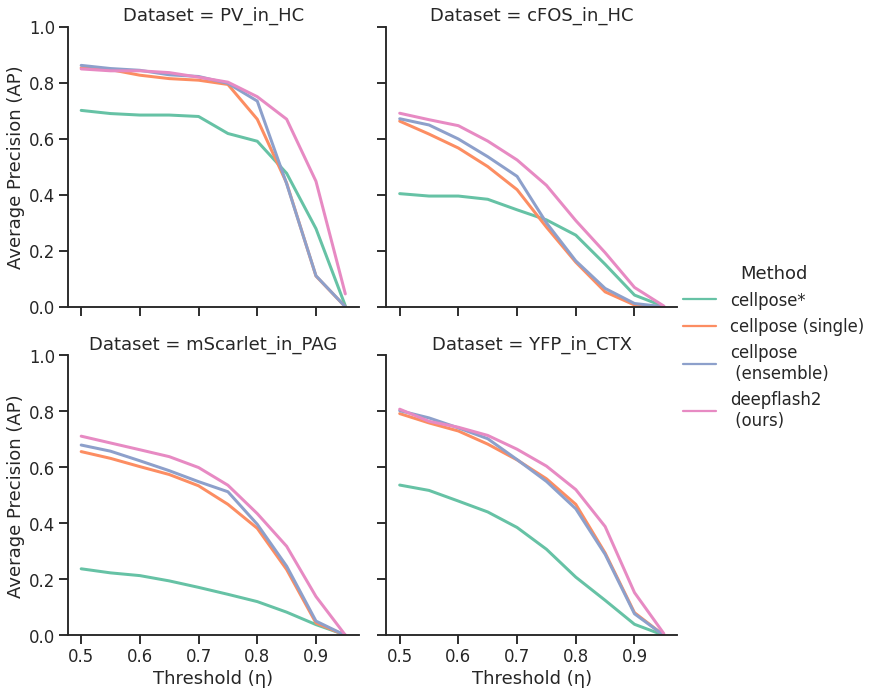

In [60]:
#@markdown Figure S2.2 code
# Settings
sns.set(style='ticks', context='talk')
metric='average_precision'
x='threshold'

# Data
df = df_instance.copy()
df = df[df.repetition==1] # Only first set of experiments
df['colors'] = df['dataset'].apply(lambda x:COLORS[x])
df['Method'] = df['method'].apply(lambda x:method_names[x])
df['Dataset'] = df['dataset']

HUE_ORDER = [method_names['cellpose'], 
         method_names['cellpose_single'],
         method_names['cellpose_ensemble'], 
         method_names['deepflash2']]

g = sns.relplot(
    data=df, 
    x='threshold', y=metric,
    col="Dataset", 
    col_wrap=2,
    ci=None,
    hue="Method", 
    hue_order=HUE_ORDER,
    kind="line",
    height=5,
    lw=3,
    palette='Set2',
)
g.set(ylim=(0., 1.),
      xlabel='Threshold (η)', 
      ylabel='Average Precision (AP)',
     );

### Figure S4.1

Uncertainty scores and out-of-distribution error categories. 
- Uncertainty score comparison for the cFOS in HC out-of-distribution dataset. 

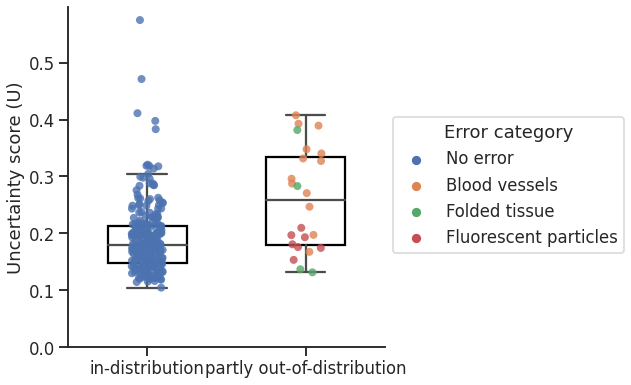

In [61]:
#@markdown Figure S4.1 code
# Settings
sns.set(style='ticks', context='talk')
y= 'uncertainty score U'

err_cat_dict = {
    'no': "No error",
    'blood_vessels': "Blood vessels",
    'bad_perf':"Blood vessels",
    'fold':"Folded tissue",
    'small_part': 'Fluorescent particles',
}
ORDER = ['in-distribution', 'partly out-of-distribution']
HUE_ORDER = ['No error', 'Blood vessels', 'Folded tissue','Fluorescent particles']

# Data
df = df_ood.copy()
df['uncertainty score U'] = df['uncertainty_score']
df['data distribution'] = df['data_distribution']
df['error category'] = df['error_category']

# Plot
g = sns.catplot(data=df, 
            x='data distribution', 
            order=ORDER,
            y=y, 
            height=6,
            width=0.5,
            fliersize=0,
            kind="box")

ax = g.axes[0][0]
for i,box in enumerate(ax.artists):
    box.set_edgecolor('black')
    box.set_facecolor('white')

sns.stripplot(data=df, 
            x='data distribution', 
            hue='error category', 
            order=ORDER,
            hue_order=HUE_ORDER,
            s=8,
            alpha=0.8,
            y=y)        

ax.legend(bbox_to_anchor=(1, .7), title='Error category')
g.set(ylim=(0,None), xlabel='', ylabel='Uncertainty score (U)')

plt.show()

In [62]:
#@markdown Figure S4.1 Mann–Whitney U test
x=df[df['data distribution']=='in-distribution']['uncertainty score U']
y=df[df['data distribution']=='partly out-of-distribution']['uncertainty score U']
pg.mwu(x, y, alternative='two-sided')

,U-val,alternative,p-val,RBC,CLES
MWU,1691.0,two-sided,0.000255,0.451686,0.274157
